In [1]:
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String
from sqlalchemy.orm import sessionmaker
from psycopg2 import sql
from conn import server

In [2]:
#ex 1 functions
def get_engine():
    engine = create_engine(f"postgresql+psycopg2://{server['user']}:{server['password']}@{server['host']}:{server['port']}/{server['dbname']}")
    return engine

def connect_postgres():
    try:
        connection = psycopg2.connect(
            host=server['host'],
            port=server['port'],
            dbname=server['dbname'],
            user=server['user'],
            password=server['password']
        )
        return connection
    except Exception as e:
        print("Error to connect:", e)

def get_json_data():
    #gets data from URL
    url = 'https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/json'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
    else:
        print('Request failed. Status code:', response.status_code)
    return data

def get_cols_type(dict_list):
    #gets the type of the data
    merged_dict = {}
    for d in dict_list:
        for key, value in d.items():
            if key not in merged_dict:
                merged_dict[key] = type(value).__name__  # gets the type of the value
    return merged_dict

def create_table(schema):
    conn = connect_postgres()
    cursor = conn.cursor()
    # Convert python data type to postgres
    type_mapping = {
        'str': 'TEXT',
        'int': 'INTEGER',
        'float': 'REAL'
    }
    # Creating cols
    columns = [sql.SQL('{} {}').format(
        sql.Identifier(column),
        sql.SQL(type_mapping[col_type])
    ) for column, col_type in schema.items()]
    create_table_query = sql.SQL("""
        CREATE TABLE IF NOT EXISTS {} (
            {}
        )
    """).format(
        sql.Identifier('covid_data'),
        sql.SQL(', ').join(columns)
    )
    cursor.execute(create_table_query)
    conn.commit()
    cursor.close()
    conn.close()

# Insert data into postgres
def insert_data(data):
    conn = connect_postgres()
    cursor = conn.cursor()
    try:
        query = "ALTER TABLE covid_data ADD CONSTRAINT unique_country_year_week UNIQUE (country, year_week, population, indicator);"
        cursor = conn.cursor()
        cursor.execute(query)
        for entry in data:
            columns = entry.keys()
            values = [entry[column] for column in columns]
            insert_query = sql.SQL("""INSERT INTO covid_data ({}) 
                                      VALUES ({}) 
                                      ON CONFLICT (country, year_week, population, indicator) DO NOTHING;""").format(
                sql.SQL(', ').join(map(sql.Identifier, columns)),
                sql.SQL(', ').join(sql.Placeholder() for _ in columns)
            )
            cursor.execute(insert_query, values)
        conn.commit()
    except Exception as e:
        print(f"An error occurred: {e}")
        conn.rollback()
    finally:
        cursor.close()
        
def create_table_countries():
    engine = get_engine()
    df = pd.read_csv('countries of the world.csv')
    df['Country'] = df['Country'].str.strip()
    df['Region'] = df['Region'].str.strip()
    df.to_sql('countries_of_world', engine, if_exists='replace', index=False)

In [3]:
data = get_json_data()
schema = get_cols_type(data)
create_table(schema)
insert_data(data) 
create_table_countries()

In [6]:
#Questions
def create_view():
    conn = connect_postgres()
    cursor = conn.cursor()
    cursor.execute('''
    CREATE OR REPLACE VIEW covid_country_view AS 
    SELECT 
        cw.*, 
        cd.weekly_count, 
        cd.cumulative_count, 
        cd.rate_14_day,
        cd.year_week
    FROM 
        "countries_of_world" cw
    JOIN 
        (
        SELECT 
            country, 
            weekly_count,
            cumulative_count,
            rate_14_day,
            year_week,
            ROW_NUMBER() OVER(PARTITION BY country ORDER BY year_week DESC) as rn
        FROM 
            "covid_data"
        ) cd 
    ON 
        cw."Country" = cd.country
    WHERE 
        cd.rn = 1;
    ''')
    conn.commit()
    cursor.close()
    conn.close()

#ex 1
def get_highest_case_per_hundredk(week):
    conn = connect_postgres()
    cursor = conn.cursor()
    sql_query = """
    SELECT 
        country,
        (CAST(weekly_count AS FLOAT) / CAST(population AS FLOAT)) * 100000 AS cases_per_100k
    FROM 
        covid_data
    WHERE 
        year_week = %s AND 
        indicator = 'cases'
    ORDER BY 
        cases_per_100k DESC
    LIMIT 1;
    """
    cursor.execute(sql_query, (week,))
    results = cursor.fetchone()
    cursor.close()
    conn.close()
    return results
    
#ex 2
def get_lowest_cases_per_hundredk(week):
    conn = connect_postgres()
    cursor = conn.cursor()
    sql_query = """
    SELECT 
        country,
        (CAST(weekly_count AS FLOAT) / CAST(population AS FLOAT)) * 100000 AS cases_per_100k
    FROM 
        covid_data
    WHERE 
        year_week = %s AND 
        indicator = 'cases'
    ORDER BY 
        cases_per_100k ASC
    LIMIT 10;
    """
    cursor.execute(sql_query, (week,))
    results = cursor.fetchall()
    cursor.close()
    conn.close()
    return results

#ex3
def get_top_cases_in_richest_countries():
    conn = connect_postgres()
    cursor = conn.cursor()
    sql_query = """
    WITH Top20Richest AS (
    SELECT 
        "Country"
    FROM 
        "countries_of_world"
    WHERE 
        "Region" LIKE '%EUROPE%'
    ORDER BY 
        "GDP ($ per capita)" DESC
    LIMIT 20
    )
    SELECT 
        cd."country", SUM(cd."weekly_count") AS "total_cases"
    FROM 
        "covid_data" cd
    WHERE 
        cd."indicator" = 'cases'
    AND 
        LOWER(cd."country") IN (SELECT LOWER("Country") FROM Top20Richest)
    GROUP BY 
        cd."country"
    ORDER BY 
        "total_cases" DESC
    LIMIT 10;
    """
    cursor.execute(sql_query)
    results = cursor.fetchall()
    cursor.close()
    conn.close()
    return results


#ex 4
def get_regions_cases_per_Million(week):
    conn = connect_postgres()
    cursor = conn.cursor()
    sql_query = """
        SELECT
            cw."Region",
            round(SUM(CASE WHEN cd."indicator" = 'cases' THEN cd."cumulative_count" ELSE 0 END) * 1000000.0 / SUM(cw."Population"), 2) AS "cases_per_million",
            MAX(cw."Pop. Density (per sq. mi.)") AS "population_density"
        FROM
            "covid_data" cd
        JOIN
            "countries_of_world" cw
            ON
            cd."country" = cw."Country"
        WHERE
            cd."year_week" = %s
        GROUP BY
            cw."Region"
        ORDER BY
            "cases_per_million" DESC;
    """
    cursor.execute(sql_query, (week,))
    results = cursor.fetchall()
    cursor.close()
    conn.close()
    return results

#ex 5
def find_covid_table_duplicates():
    conn = connect_postgres()
    cursor = conn.cursor()
    sql_query = """
    SELECT
        (covid_data.*)::text, count(*)
    FROM 
        covid_data
    GROUP BY 
        covid_data.*
    HAVING count(*) > 1
    """
    cursor.execute(sql_query)
    results = cursor.fetchall() 
    cursor.close()
    conn.close()
    if results:
        return results
    return 'No Duplicates' 


def find_countires_table_duplicates():
    conn = connect_postgres()
    cursor = conn.cursor()
    sql_query = """
    SELECT (countries_of_world .*)::text, count(*)
    FROM 
        countries_of_world
    GROUP BY 
        countries_of_world.*
    HAVING count(*) > 1
    """
    cursor.execute(sql_query)
    results = cursor.fetchall() 
    cursor.close()
    conn.close()
    if results:
        return results
    return 'No Duplicates' 

In [21]:
create_view()
print("Country with the highest number of cases per 100,000 inhabitants", get_highest_case_per_hundredk('2020-31'))
print("Top 10 countries with the lowest number of cases per 100k inhabitants", get_lowest_cases_per_hundredk('2020-31'))
print("Top 10 countries with the highest number of cases among the 20 richest countries", get_top_cases_in_richest_countries())
print("Regions with the number of cases per million inhabitants", get_regions_cases_per_Million('2020-31'))
print(find_covid_table_duplicates())
print(find_countires_table_duplicates())

Country with the highest number of cases per 100,000 inhabitants ('Luxembourg', 55.00490395833883)
Top 10 countries with the lowest number of cases per 100k inhabitants [('Hungary', 0.9908133029071081), ('Latvia', 1.2794834298899058), ('Finland', 1.5139933539296508), ('Slovakia', 3.091240161392177), ('Estonia', 3.378895866934575), ('Lithuania', 3.5637944146788416), ('Norway', 3.6680202091324485), ('Italy', 3.743850619479377), ('Slovenia', 4.460938315663588), ('Liechtenstein', 5.088022794342119)]
Top 10 countries with the highest number of cases among the 20 richest countries [('France', 40086999), ('Germany', 38437756), ('Italy', 26572157), ('Netherlands', 8619835), ('Austria', 6084155), ('Belgium', 4808377), ('Denmark', 3106460), ('Sweden', 2717595), ('Ireland', 1722454), ('Norway', 1489846)]
Regions with the number of cases per million inhabitants [('WESTERN EUROPE', Decimal('1787.13'), '97,7'), ('NEAR EAST', Decimal('794.34'), '84,8'), ('BALTICS', Decimal('742.38'), '55,0'), ('EASTE

## **Analyze the performance of all the queries and describes what you see. Get improvements suggestions.**

 - In queries to find duplicates, I could also use some types of filters such as week, countries and cases to find a duplicate, but this check is already being done in the insert

In [8]:
def create_table_vaccine():
    engine = get_engine()
    df = pd.read_csv('vaccinations.csv')
    df.to_sql('vaccinations', engine, if_exists='replace', index=False)

In [9]:
create_table_vaccine()

## **Enrich the information with any other piece of data (available on the web) and justify the choice.**

 - The dataset chosen was about global vaccination where with it we can see the evolution of the vaccine over time and relate it both to the covid dataset and countries of the world
(https://www.kaggle.com/datasets/kingabzpro/world-vaccine-progress?rvi=1&select=world_time_series.csv)

In [18]:
def create_view_covid_evolution_europe():
    conn = connect_postgres()
    cursor = conn.cursor()
    cursor.execute('''
    CREATE OR REPLACE VIEW covid_evolution_europe AS 
    SELECT cd.year_week, cd.country, cd.weekly_count, cd.indicator
    FROM covid_data cd
    JOIN countries_of_world cw ON cd.country = cw."Country"
    WHERE cw."Region" LIKE '%EUROPE%'
      AND cd.indicator IN ('cases', 'deaths')
    ORDER BY cd.country, cd.year_week;
    ''')
    conn.commit()
    cursor.close()
    conn.close()


def create_view_vax():
    conn = connect_postgres()
    cursor = conn.cursor()
    cursor.execute('''
    CREATE OR REPLACE VIEW europe_vaccination_deaths AS
    SELECT
        va.location AS country,
        va.date AS vaccination_date,
        va.total_vaccinations,
        cd.year_week,
        cd.weekly_count AS weekly_deaths
    FROM 
        vaccinations va
    JOIN 
        covid_data cd
    ON 
        va.location = cd.country
    WHERE 
        cd.indicator = 'deaths'
        AND va.location IN (
            'Austria', 'Belgium', 'Croatia',
            'Finland', 'France', 'Germany', 'Greece',
            'Hungary', 'Ireland', 'Italy', 'Latvia','Netherlands', 'Poland',
            'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden'
        );
    ''')
    conn.commit()
    cursor.close()
    conn.close()

def create_view_covid_evolution():
    conn = connect_postgres()
    cursor = conn.cursor()
    cursor.execute('''
    CREATE OR REPLACE VIEW public.covid_evolution_europe
    AS SELECT cd.year_week,
        cd.country,
        cd.weekly_count,
        cd.indicator
       FROM covid_data cd
         JOIN countries_of_world cw ON cd.country::text = cw."Country"
      WHERE cw."Region" LIKE '%EUROPE%'::text AND (cd.indicator::text = ANY (ARRAY['cases'::character varying, 'deaths'::character varying]::text[]))
      ORDER BY cd.country, cd.year_week;
    ''')
    conn.commit()
    cursor.close()
    conn.close()


def create_view_covid_vax_gdp():
    conn = connect_postgres()
    cursor = conn.cursor()
    cursor.execute('''
    CREATE OR REPLACE VIEW public.latest_vaccination_and_gdp
    AS SELECT va.location,
        va.date,
        va.people_vaccinated,
        cw."GDP ($ per capita)"
       FROM ( SELECT vaccinations.location,
                vaccinations.date,
                vaccinations.people_vaccinated
               FROM vaccinations
              WHERE ((vaccinations.location, vaccinations.date) IN ( SELECT vaccinations_1.location,
                        max(vaccinations_1.date) AS max
                       FROM vaccinations vaccinations_1
                      GROUP BY vaccinations_1.location))) va
         JOIN countries_of_world cw ON va.location = cw."Country";
    ''')
    conn.commit()
    cursor.close()
    conn.close()

def create_view_covid_country():
    conn = connect_postgres()
    cursor = conn.cursor()
    cursor.execute('''
    CREATE OR REPLACE VIEW public.covid_and_country_data
    AS SELECT cd.country,
        cd.year_week,
        cd.weekly_count,
        cw."Population",
        cw."Area (sq. mi.)",
        cw."Population" / cw."Area (sq. mi.)" AS population_density
       FROM covid_data cd
         JOIN countries_of_world cw ON cd.country::text = cw."Country"
      WHERE cd.indicator::text = 'cases'::text;
    ''')
    conn.commit()
    cursor.close()
    conn.close()

def evolution_europe():
    engine = get_engine()
    query = "SELECT * FROM covid_evolution_europe;"
    df_covid_europe = pd.read_sql(query, engine)
    df_covid_europe['date'] = pd.to_datetime(df_covid_europe['year_week'].add('-1'), format='%Y-%W-%w')
    plt.figure(figsize=(12, 6)) 
    plt.plot(
        df_covid_europe[df_covid_europe['indicator'] == 'cases'].groupby('date')['weekly_count'].sum().index,
        df_covid_europe[df_covid_europe['indicator'] == 'cases'].groupby('date')['weekly_count'].sum().values,
        label='Cases'
    )
    plt.title('Aggregated COVID-19 Cases Over Time in Europe')
    plt.xlabel('Date')
    plt.ylabel('Weekly Count of cases')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    description = (
    "We can clearly observe the beginning, waves and end of the pandemic through this graph, that is, the entire pandemic through cases"
    "It would be interesting to compare these spikes with events or measures taken by governments"
    )
    plt.figtext(0.5, -0.05, description, ha="center", va="center", fontsize=10, wrap=True)
    plt.xticks(df_covid_europe['date'].unique()[::4], rotation=45)
    plt.show()
    
def vax_gdp():
    engine = get_engine()
    query = "SELECT * FROM latest_vaccination_and_gdp"
    df = pd.read_sql(query, engine)
    nan_check = df['people_vaccinated'].isna().sum(), df.shape
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='GDP ($ per capita)', y='people_vaccinated', data=df)
    plt.title('Relationship Between GDP per Capita and Total Vaccinations')
    plt.xlabel('GDP ($ per capita)')
    plt.ylabel('Total Vaccinations')
    plt.grid(True)
    plt.tight_layout()
    description = ("We can observe whether there is any relationship between a country's purchasing power and vaccination. From this graph we can see that there is not such a large discrepancy")
    plt.figtext(0.5, -0.05, description, ha="center", va="center", fontsize=10, wrap=True)
    plt.show()

def cases_density_area():
    engine = get_engine()
    query = "SELECT * FROM covid_and_country_data;"
    df = pd.read_sql(query, engine)
    df['weekly_count'] = pd.to_numeric(df['weekly_count'], errors='coerce')
    df['population_density'] = pd.to_numeric(df['population_density'], errors='coerce')
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='population_density', y='weekly_count', data=df)
    plt.title('Relationship Between Population Density and Weekly Increase in Cases')
    plt.xlabel('Population Density (people per sq. mi.)')
    plt.ylabel('Weekly Increase in Cases')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Area (sq. mi.)', y='weekly_count', data=df)
    plt.title('Relationship Between Country Area and Weekly Increase in Cases')
    plt.xlabel('Country Area (sq. mi.)')
    plt.ylabel('Weekly Increase in Cases')
    plt.grid(True)
    plt.tight_layout()
    description = ("Most countries appear to have a smaller area and a wider range of weekly increases in cases, which could indicate that country size is not the only determining factor in the spread of the virus.")
    plt.figtext(0.5, -0.05, description, ha="center", va="center", fontsize=10, wrap=True)
    plt.show()


def total_vaccination_and_death():
    engine = get_engine()
    query = "SELECT * FROM europe_vaccination_deaths;"
    df = pd.read_sql(query, engine)
    df['vaccination_date'] = pd.to_datetime(df['vaccination_date'])
    df.set_index('vaccination_date', inplace=True)
    df_weekly = df.resample('W').sum() 
    df_weekly.reset_index(inplace=True)
    plt.figure(figsize=(14, 6))
    plt.plot(df_weekly['vaccination_date'], df_weekly['total_vaccinations'], label='Total Vaccinations', color='blue') 
    ax2 = plt.gca().twinx()
    ax2.plot(df_weekly['vaccination_date'], df_weekly['weekly_deaths'], label='Weekly Deaths', color='red', linestyle='--')
    plt.title('Total Vaccinations and Weekly Deaths Over Time in Europe (Weekly Data)')
    plt.xlabel('Date')
    plt.ylabel('Total Vaccinations')
    ax2.set_ylabel('Weekly Deaths')
    plt.legend(loc='upper left')
    ax2.legend(loc='upper right')
    description = ("we can clearly see the drop in deaths in countries after the increase in time and people immunized")
    plt.figtext(0.5, -0.05, description, ha="center", va="center", fontsize=10, wrap=True)
    plt.tight_layout()
    plt.show()

    

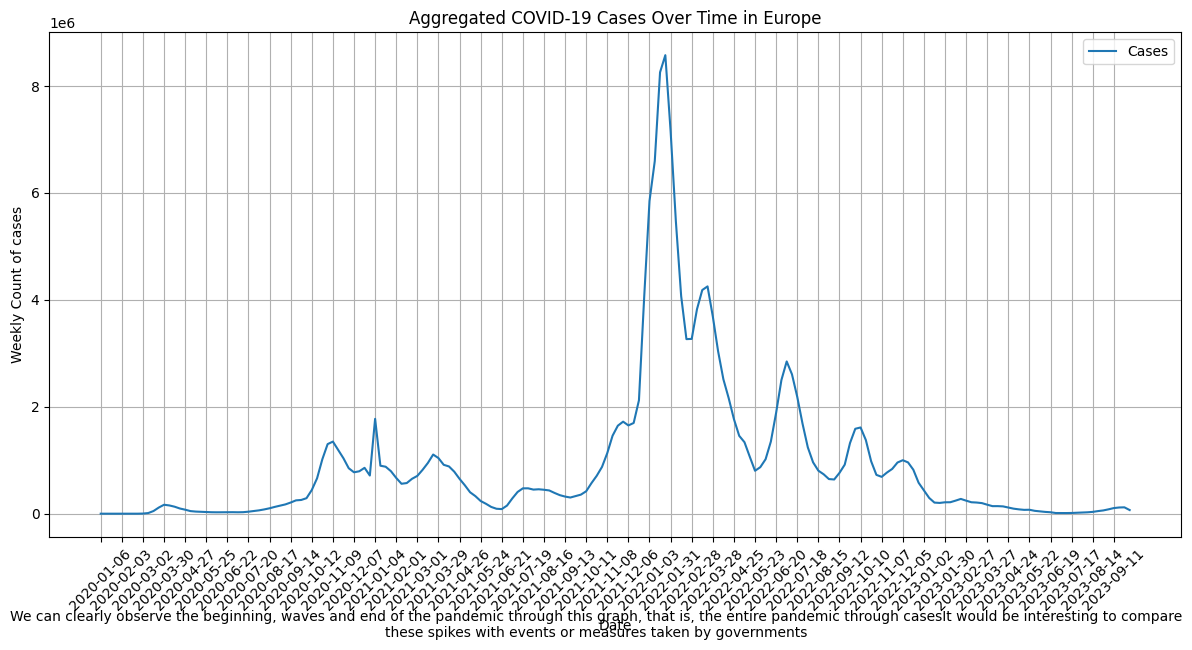

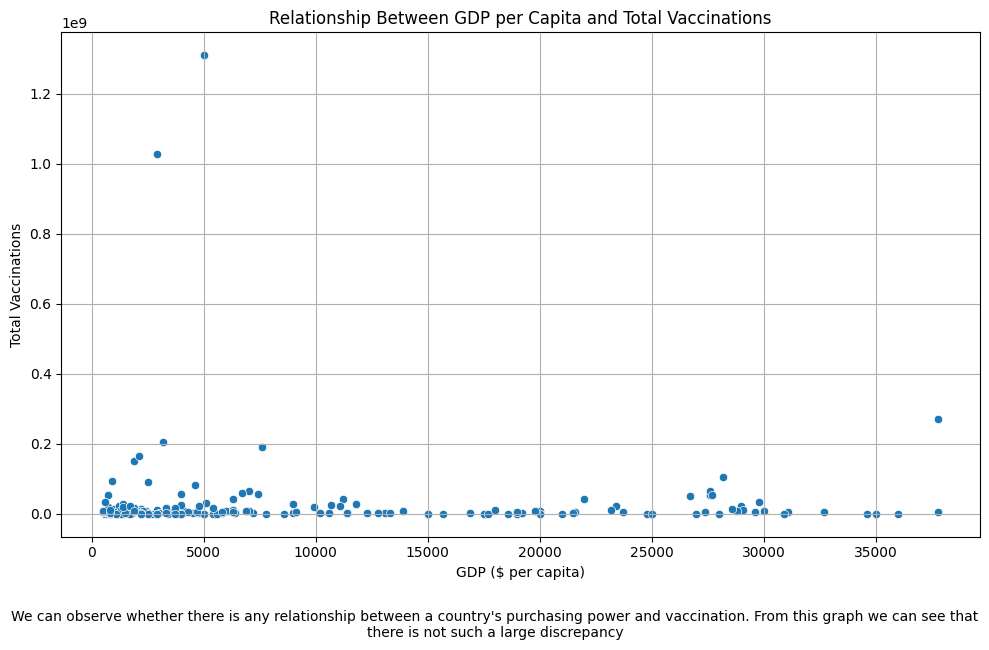

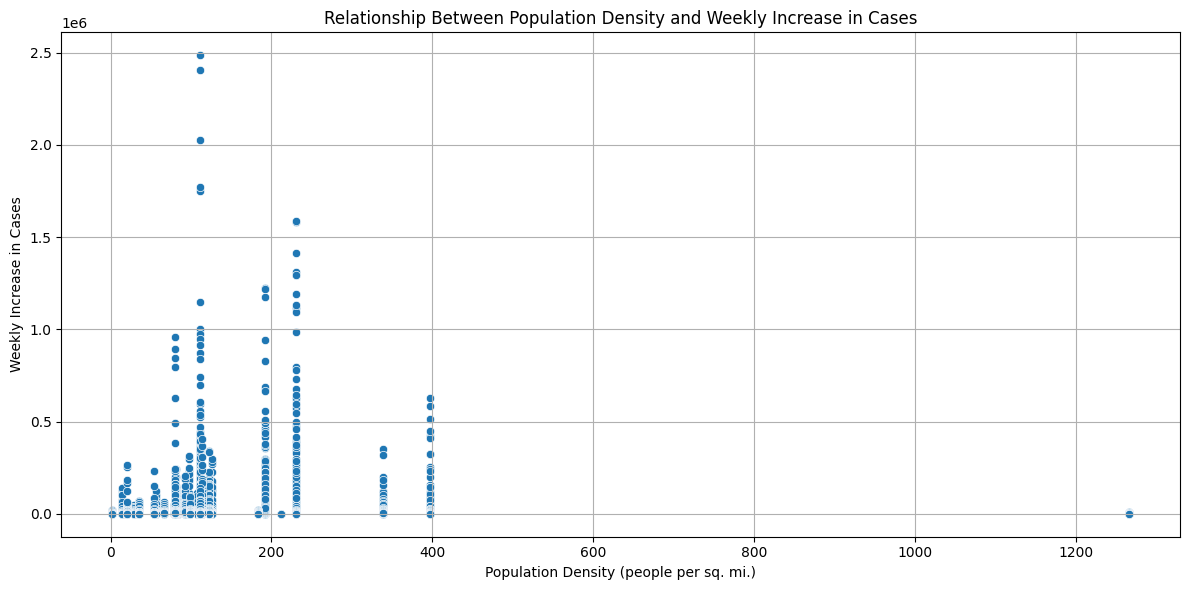

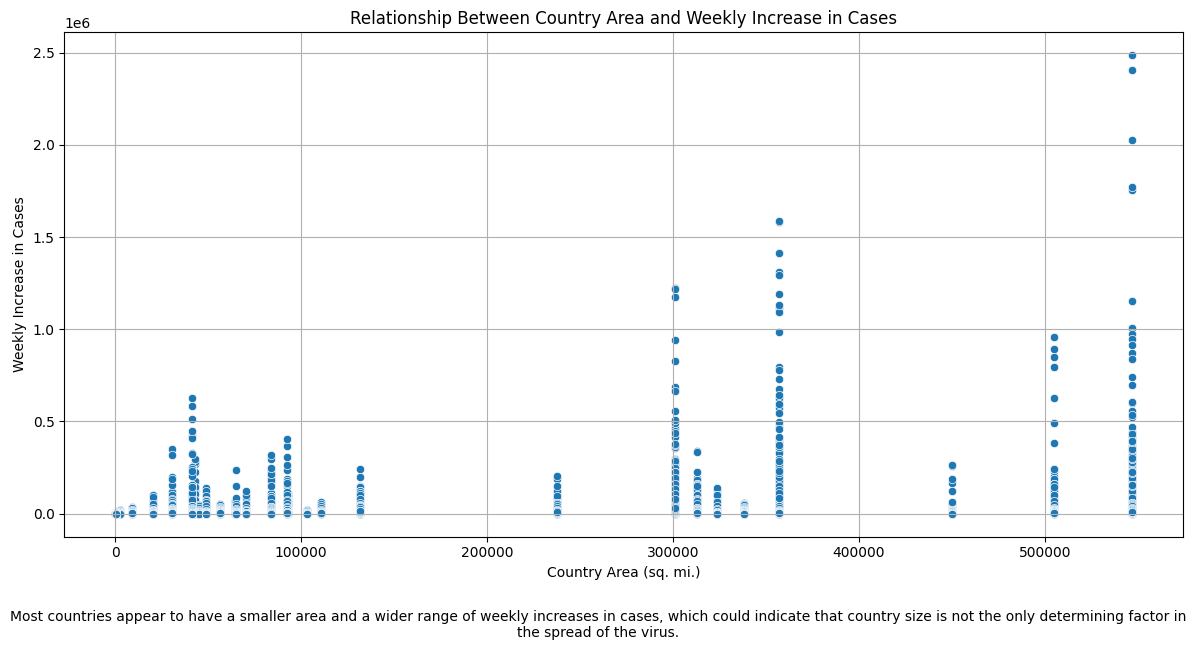

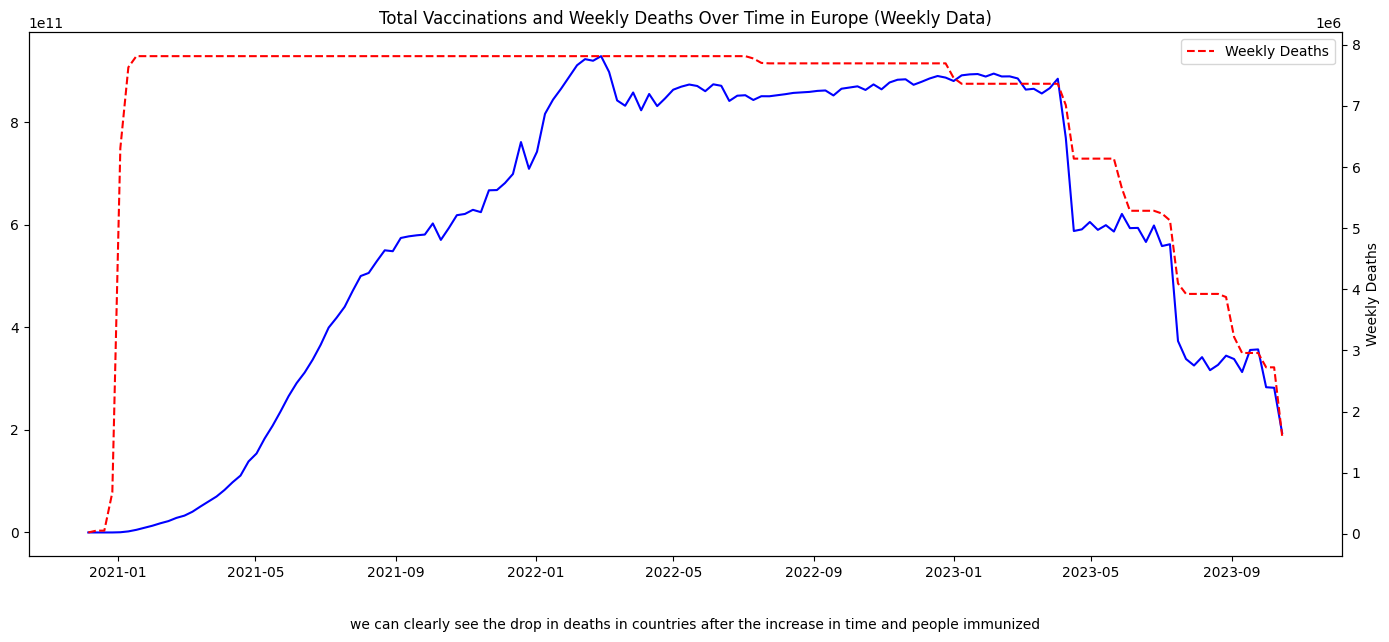

In [19]:
create_view_covid_evolution_europe()
evolution_europe()
create_view_covid_vax_gdp()
vax_gdp()
create_view_covid_country()
cases_density_area()
create_view_vax()
total_vaccination_and_death()